In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import muon as mu
import scanpy as sc
import umap
import pandas as pd
import numpy as np

from prismo.prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions
from prismo.gpu import get_free_gpu_idx
from prismo.io import load_model
from prismo.downstream import match
from prismo.plotting import plot_training_curve, plot_variance_explained, plot_factor_correlation, plot_factors_scatter

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# plotting settings
# sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

In [5]:
def load_mdata(data="208", union=False, shuffle=False):

    if data == "208":
        path = "../../muvi-framework/data/sln_208.h5ad"
    if data == "111":
        path = "../../muvi-framework/data/sln_111.h5ad"

    relevant_cell_types = [
        "Activated CD4 T",
        # 'B doublets',
        # 'B-CD4 T cell doublets',
        # 'B-CD8 T cell doublets',
        # 'B-macrophage doublets',
        "B1 B",
        "CD122+ CD8 T",
        "CD4 T",
        "CD8 T",
        # 'Cycling B/T cells',
        "Erythrocytes",
        "GD T",
        "ICOS-high Tregs",
        "Ifit3-high B",
        "Ifit3-high CD4 T",
        "Ifit3-high CD8 T",
        # 'Low quality B cells',
        # 'Low quality T cells',
        "Ly6-high mono",
        "Ly6-low mono",
        "MZ B",
        "MZ/Marco-high macrophages",
        "Mature B",
        "Migratory DCs",
        "NK",
        "NKT",
        "Neutrophils",
        "Plasma B",
        "Red-pulp macrophages",
        # 'T doublets',
        "Transitional B",
        "Tregs",
        "cDC1s",
        "cDC2s",
        "pDCs",
    ]

    adata = sc.read_h5ad(path)
    adata.var_names_make_unique()
    adata.X = np.array(adata.X.todense(), dtype=np.float32)

    adata.obs_names = adata.obs_names.str.upper()
    adata.var_names = adata.var_names.str.upper()

    adata._inplace_subset_var(adata.var["highly_variable"])

    adata._inplace_subset_obs(adata.obs["cell_types"].isin(relevant_cell_types))
    adata.obs["cell_types"] = adata.obs["cell_types"].cat.remove_unused_categories()
    adata.obs["source"] = data

    prot_df = pd.DataFrame(
        adata.obsm["protein_expression"],
        index=adata.obs_names,
        columns=pd.Index(adata.uns["protein_names"]).str.upper(),
        dtype=np.float32,
    )
    if not union:
        prot_df = prot_df.dropna(axis=1, how="all")
    if shuffle:
        shuffled_obs = adata.obs_names[np.random.permutation(adata.n_obs)]
        adata = adata[shuffled_obs, :].copy()
        prot_df = prot_df.loc[shuffled_obs, :].copy()
    prot_adata = sc.AnnData(prot_df)
    return mu.MuData(
        {
            "rna": adata,
            "prot": prot_adata,
        }
    )

In [6]:
def merge_mdata(mdata_1, mdata_2):
    adata_dict = {}
    for k in mdata_1.mod.keys():
        df_1 = mdata_1[k].to_df()
        obs_1 = mdata_1[k].obs.copy()
        var_1 = mdata_1[k].var.copy()

        df_2 = mdata_2[k].to_df()
        obs_2 = mdata_2[k].obs.copy()
        var_2 = mdata_2[k].var.copy()
        # assert (var_1 == var_2).all(None)

        df_concat = pd.concat([df_1, df_2])
        unique_indices = ~df_concat.index.duplicated(False)
        df_concat = df_concat.loc[unique_indices, :].copy()
        # assert (df_1.columns == df_concat.columns).all()

        obs_1["source"] = 1
        obs_2["source"] = 2
        obs_concat = pd.concat([obs_1, obs_2]).loc[unique_indices, :].copy()

        adata_dict[k] = sc.AnnData(df_concat, obs=obs_concat, var=var_1)

    return mu.MuData(adata_dict)

In [7]:
mdata_208 = load_mdata("208", shuffle=False)
mdata_111 = load_mdata("111", shuffle=False)

# TODO: IF YOU MERGE MAKE SURE TO SET shuffle=False!
# mdata = merge_mdata(mdata_208, mdata_111)
mdata = mdata_208
mdata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on

MuData object with n_obs × n_vars = 14870 × 4112
  2 modalities
    rna:	14870 x 4000
      obs:	'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source'
      var:	'gene_ids', 'feature_types', 'highly_variable', 'encode', 'hvg_encode'
      uns:	'protein_names', 'version'
      obsm:	'isotypes_htos', 'protein_expression'
    prot:	14870 x 112

In [8]:
cell_type_map = {
    "Mature B": "B",
    "Transitional B": "B",
    "Ifit3-high B": "B",
    "MZ B": "B",
    "B1 B": "B",
    "Plasma B": "B",
    "CD4 T": "CD4",
    "Ifit3-high CD4 T": "CD4",
    "Activated CD4 T": "CD4",
    "CD8 T": "CD8",
    "CD122+ CD8 T": "CD8",
    "Ifit3-high CD8 T": "CD8",
    "Tregs": "Tregs",
    "ICOS-high Tregs": "Tregs",
    # 'GD T': 'GD T',
    "NKT": "NK",
    "NK": "NK",
    "Neutrophils": "Neutrophils",
    "Ly6-high mono": "Ly6",
    "Ly6-low mono": "Ly6",
    "cDC2s": "DC",
    "cDC1s": "DC",
    "Migratory DCs": "DC",
    "pDCs": "DC",
    "Erythrocytes": "Erythrocytes",
    "MZ/Marco-high macrophages": "Macrophages",
    "Red-pulp macrophages": "Macrophages",
}


mdata["rna"].obs["cell types (high)"] = (
    mdata.obs["rna:cell_types"].map(cell_type_map).astype("category")
)

In [9]:
mdata.obs["rna:batch"].value_counts()

rna:batch
SLN208-D1    8265
SLN208-D2    6605
Name: count, dtype: int64

In [10]:
center = False
for view_name, adata in mdata.mod.items():
    adata.X = np.log1p(adata.X)
    if center:
        adata.X = adata.X - np.nanmean(adata.X, axis=0)
    else:
        adata.X = adata.X - np.nanmin(adata.X, axis=0)
    print(f"Current shape of {view_name}: {adata.shape}")
    global_std = np.nanstd(adata.X)
    print(f"Global std of {view_name} before: {global_std}")
    adata.X /= global_std
    print(f"Global std of {view_name}: {np.nanstd(adata.X)}")

mdata.update()

Current shape of rna: (14870, 4000)
Global std of rna before: 0.3643924295902252
Global std of rna: 0.9999992847442627
Current shape of prot: (14870, 112)
Global std of prot before: 1.142163634300232
Global std of prot: 1.0000001192092896


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


<Axes: >

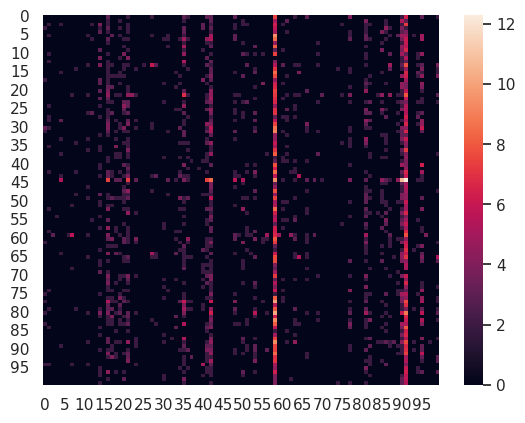

In [11]:
# visual check
sns.heatmap(mdata["rna"].X[:100, :100])

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [12]:
from prismo import feature_sets

In [13]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [14]:
hallmark_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/mh.all.v2023.2.Mm.symbols.gmt", name="hallmark"
)
reactome_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/m2.cp.reactome.v2023.2.Mm.symbols.gmt", name="reactome"
)

# celltype_collection = feature_sets.from_gmt(
#     "../msigdb/m8.all.v2023.2.Mm.symbols.gmt", name="celltype"
# )

celltype_collection = feature_sets.from_gmt(
    "../../muvi-framework/raw_signatures/mmc5_gene.gmt", name="celltype"
)

# merge both collections
gene_set_collection = hallmark_collection | celltype_collection
gene_set_collection = to_upper(gene_set_collection)

In [15]:
# sorted([fs.name for fs in gene_set_collection if "HAN" in fs.name])

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [16]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15, max_count=300
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'hallmark|celltype' with 56 feature sets>

In [17]:
gene_set_collection.median_size

69

In [18]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    mdata["rna"].var_names.tolist()
).T

In [19]:
mdata["prot"].varm["gene_set_mask"] = pd.DataFrame(False, index=mdata["prot"].var_names, columns=mdata["rna"].varm["gene_set_mask"].columns)

In [20]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:3'

In [21]:
data_opts = DataOptions(
    group_by=None, 
    scale_per_group=False, 
    covariates_obs_key=None, 
    covariates_obsm_key=None, 
    use_obs=None, 
    use_var=None, 
    plot_data_overview=False
)

In [22]:
model_opts = ModelOptions(
    n_factors=3,
    weight_prior="Horseshoe",
    factor_prior="Normal",
    likelihoods={"rna": "Normal", "prot": "Normal"},
    nonnegative_weights=True,
    nonnegative_factors=True,
    annotations=None,
    annotations_varm_key={"rna": "gene_set_mask"},
    prior_penalty=0.01,
    # init_factors="random",
    init_factors=0.0,
    init_scale=0.1
)

In [23]:
training_opts = TrainingOptions(
    device=device, 
    batch_size=0,
    max_epochs=10000, 
    n_particles=1, 
    lr=0.005, 
    early_stopper_patience=100, 
    print_every=500, 
    save=False, 
    save_path=None, 
    # 2411091114
    seed=2412011746
)

In [24]:
model = PRISMO(mdata, data_opts, model_opts, training_opts)

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
2024-12-01 17:59:14 | prismo.prismo | INFO | Setting up device...
2024-12-01 17:59:14 | prismo.prismo | INFO | - Checking compatibility of provided likelihoods with data.
2024-12-01 17:59:14 | prismo.prismo | INFO |   - rna: Normal


In [25]:
old_factor_names = model._factor_names.copy()
# model._factor_names = old_factor_names.copy()

In [26]:
from prismo import downstream

In [27]:
# test_results = downstream.test(model)

In [28]:
# p_adj_df = test_results["pos"]["rna"]["p_adj"].copy()
# p_adj_df.head()

In [29]:
# significant_factors = pd.Series(np.diagonal(p_adj_df.loc[p_adj_df.columns, p_adj_df.columns]), index=p_adj_df.columns) < 0.05
# significant_factors.head()

In [30]:
# first, lets prettify the names of the factors
# assume format: COLLECTION_SOME_LONG_GENE_SET_NAME|COLLECTION_SOME_OTHER_LONG_GENE_SET_NAME
# return format: Some Long...Name (C)|Some Other...Name (C)
def prettify(name, max_len=50):
    parts = name.split("_")
    if "Factor" not in name:
        parts[0] = f"({parts[0][0:4]})"
        parts = parts[1:] + parts[:1]
    new_name = " ".join(parts)
    if len(new_name) > max_len:
        half_len = (max_len) // 2
        new_name = new_name[: half_len - 2] + "..." + new_name[-half_len + 1 :]
    return new_name.title()

In [31]:
def invert_permutation(p):
    p = np.asanyarray(p)
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s

In [32]:
model.factor_names

array(['Factor 2', 'Factor 1', 'Factor 3', 'HAN_MARGINAL ZONE B CELL',
       'HAN_T CELL', 'HAN_DENDRITIC CELL_S100A4 HIGH',
       'HALLMARK_PROTEIN_SECRETION', 'HAN_PLASMA CELL',
       'HALLMARK_ADIPOGENESIS', 'HALLMARK_APOPTOSIS',
       'HALLMARK_MYC_TARGETS_V1', 'HAN_MONOCYTE', 'HALLMARK_P53_PATHWAY',
       'HAN_NK CELL', 'HAN_MACROPHAGE', 'HAN_GRANULOCYTE',
       'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'HAN_NEUTROPHIL',
       'HALLMARK_GLYCOLYSIS', 'HAN_DENDRITIC CELL_SIGLECH HIGH',
       'HALLMARK_ANGIOGENESIS', 'HALLMARK_INFLAMMATORY_RESPONSE',
       'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_ANDROGEN_RESPONSE',
       'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_KRAS_SIGNALING_UP',
       'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_KRAS_SIGNALING_DN',
       'HALLMARK_UV_RESPONSE_UP', 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
       'HALLMARK_APICAL_JUNCTION',
       'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
       'HALLMARK_COMPLEMENT', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
       'HAL

In [33]:
# factor_name_offset = 1
# factor_names = []
# for fn in model.factor_names:
#     if "Factor" in fn or not significant_factors.loc[fn]:
#         factor_names.append(f"Factor_{factor_name_offset}")
#         factor_name_offset += 1
#     else:
#       factor_names.append(fn)
# model._factor_names = pd.Index([prettify(fn) for fn in factor_names])[invert_permutation(model.factor_order)]

In [34]:
from prismo import plotting

In [35]:
from plotting import plot_top_weights, rank, groupplot_rank, scatter

In [36]:
model._df_r2_full

{'group_1': rna     0.646395
 prot    0.960019
 dtype: float64}

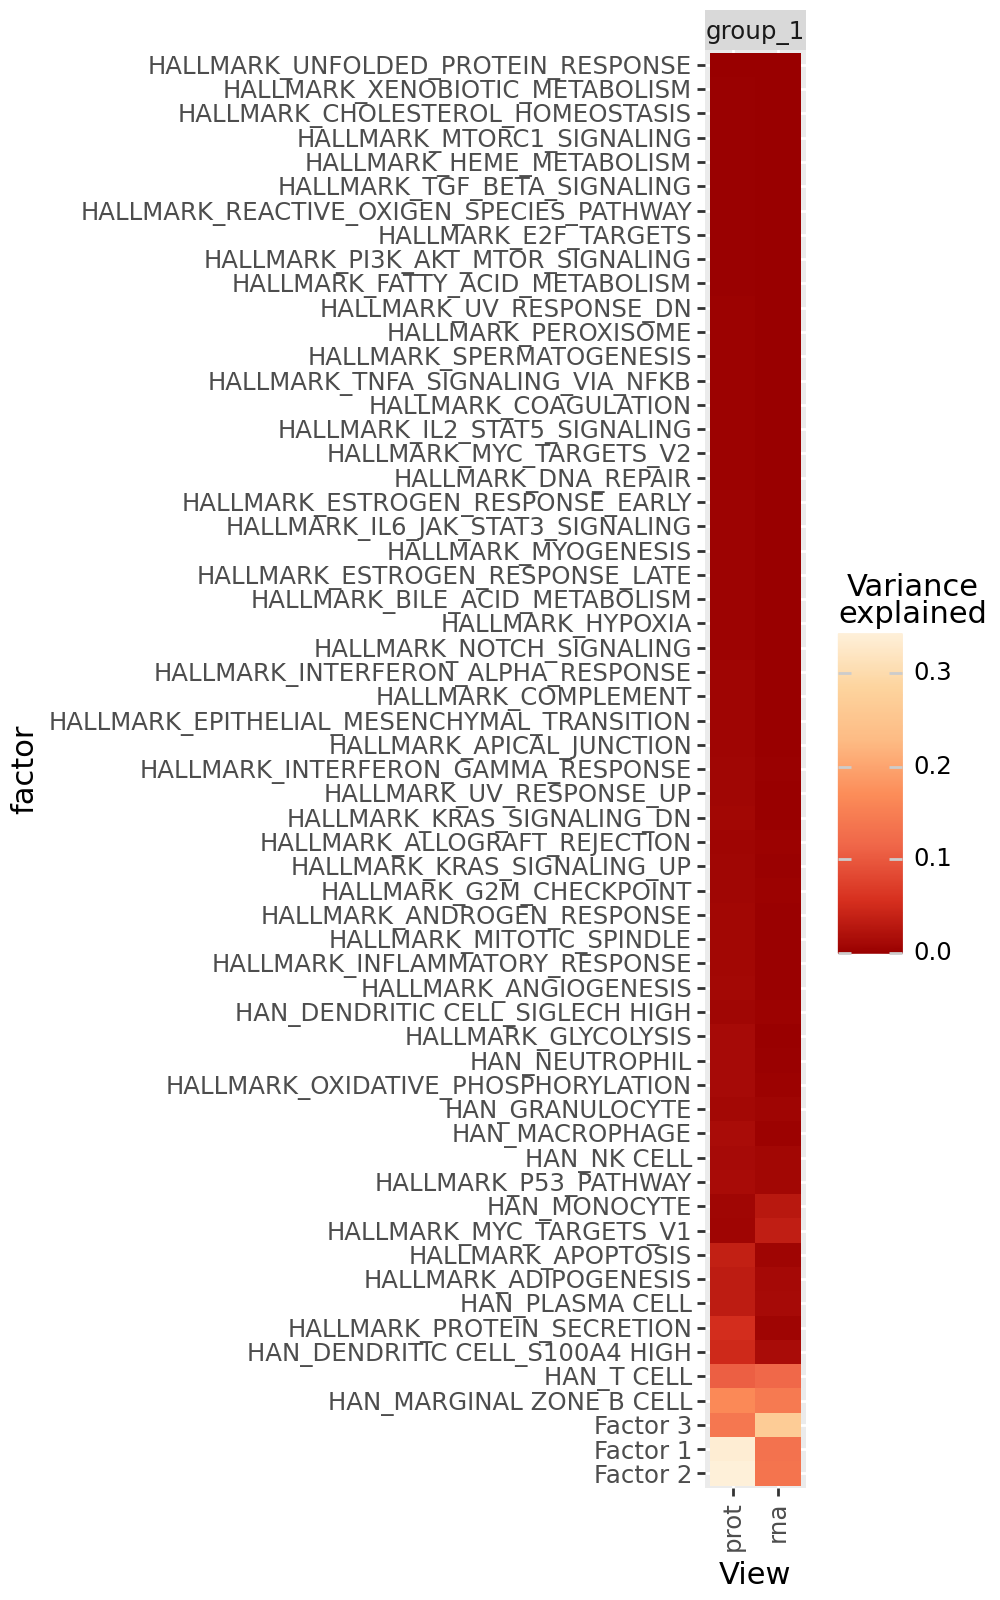

In [37]:
plotting.plot_variance_explained(model, figsize=(5, 8))

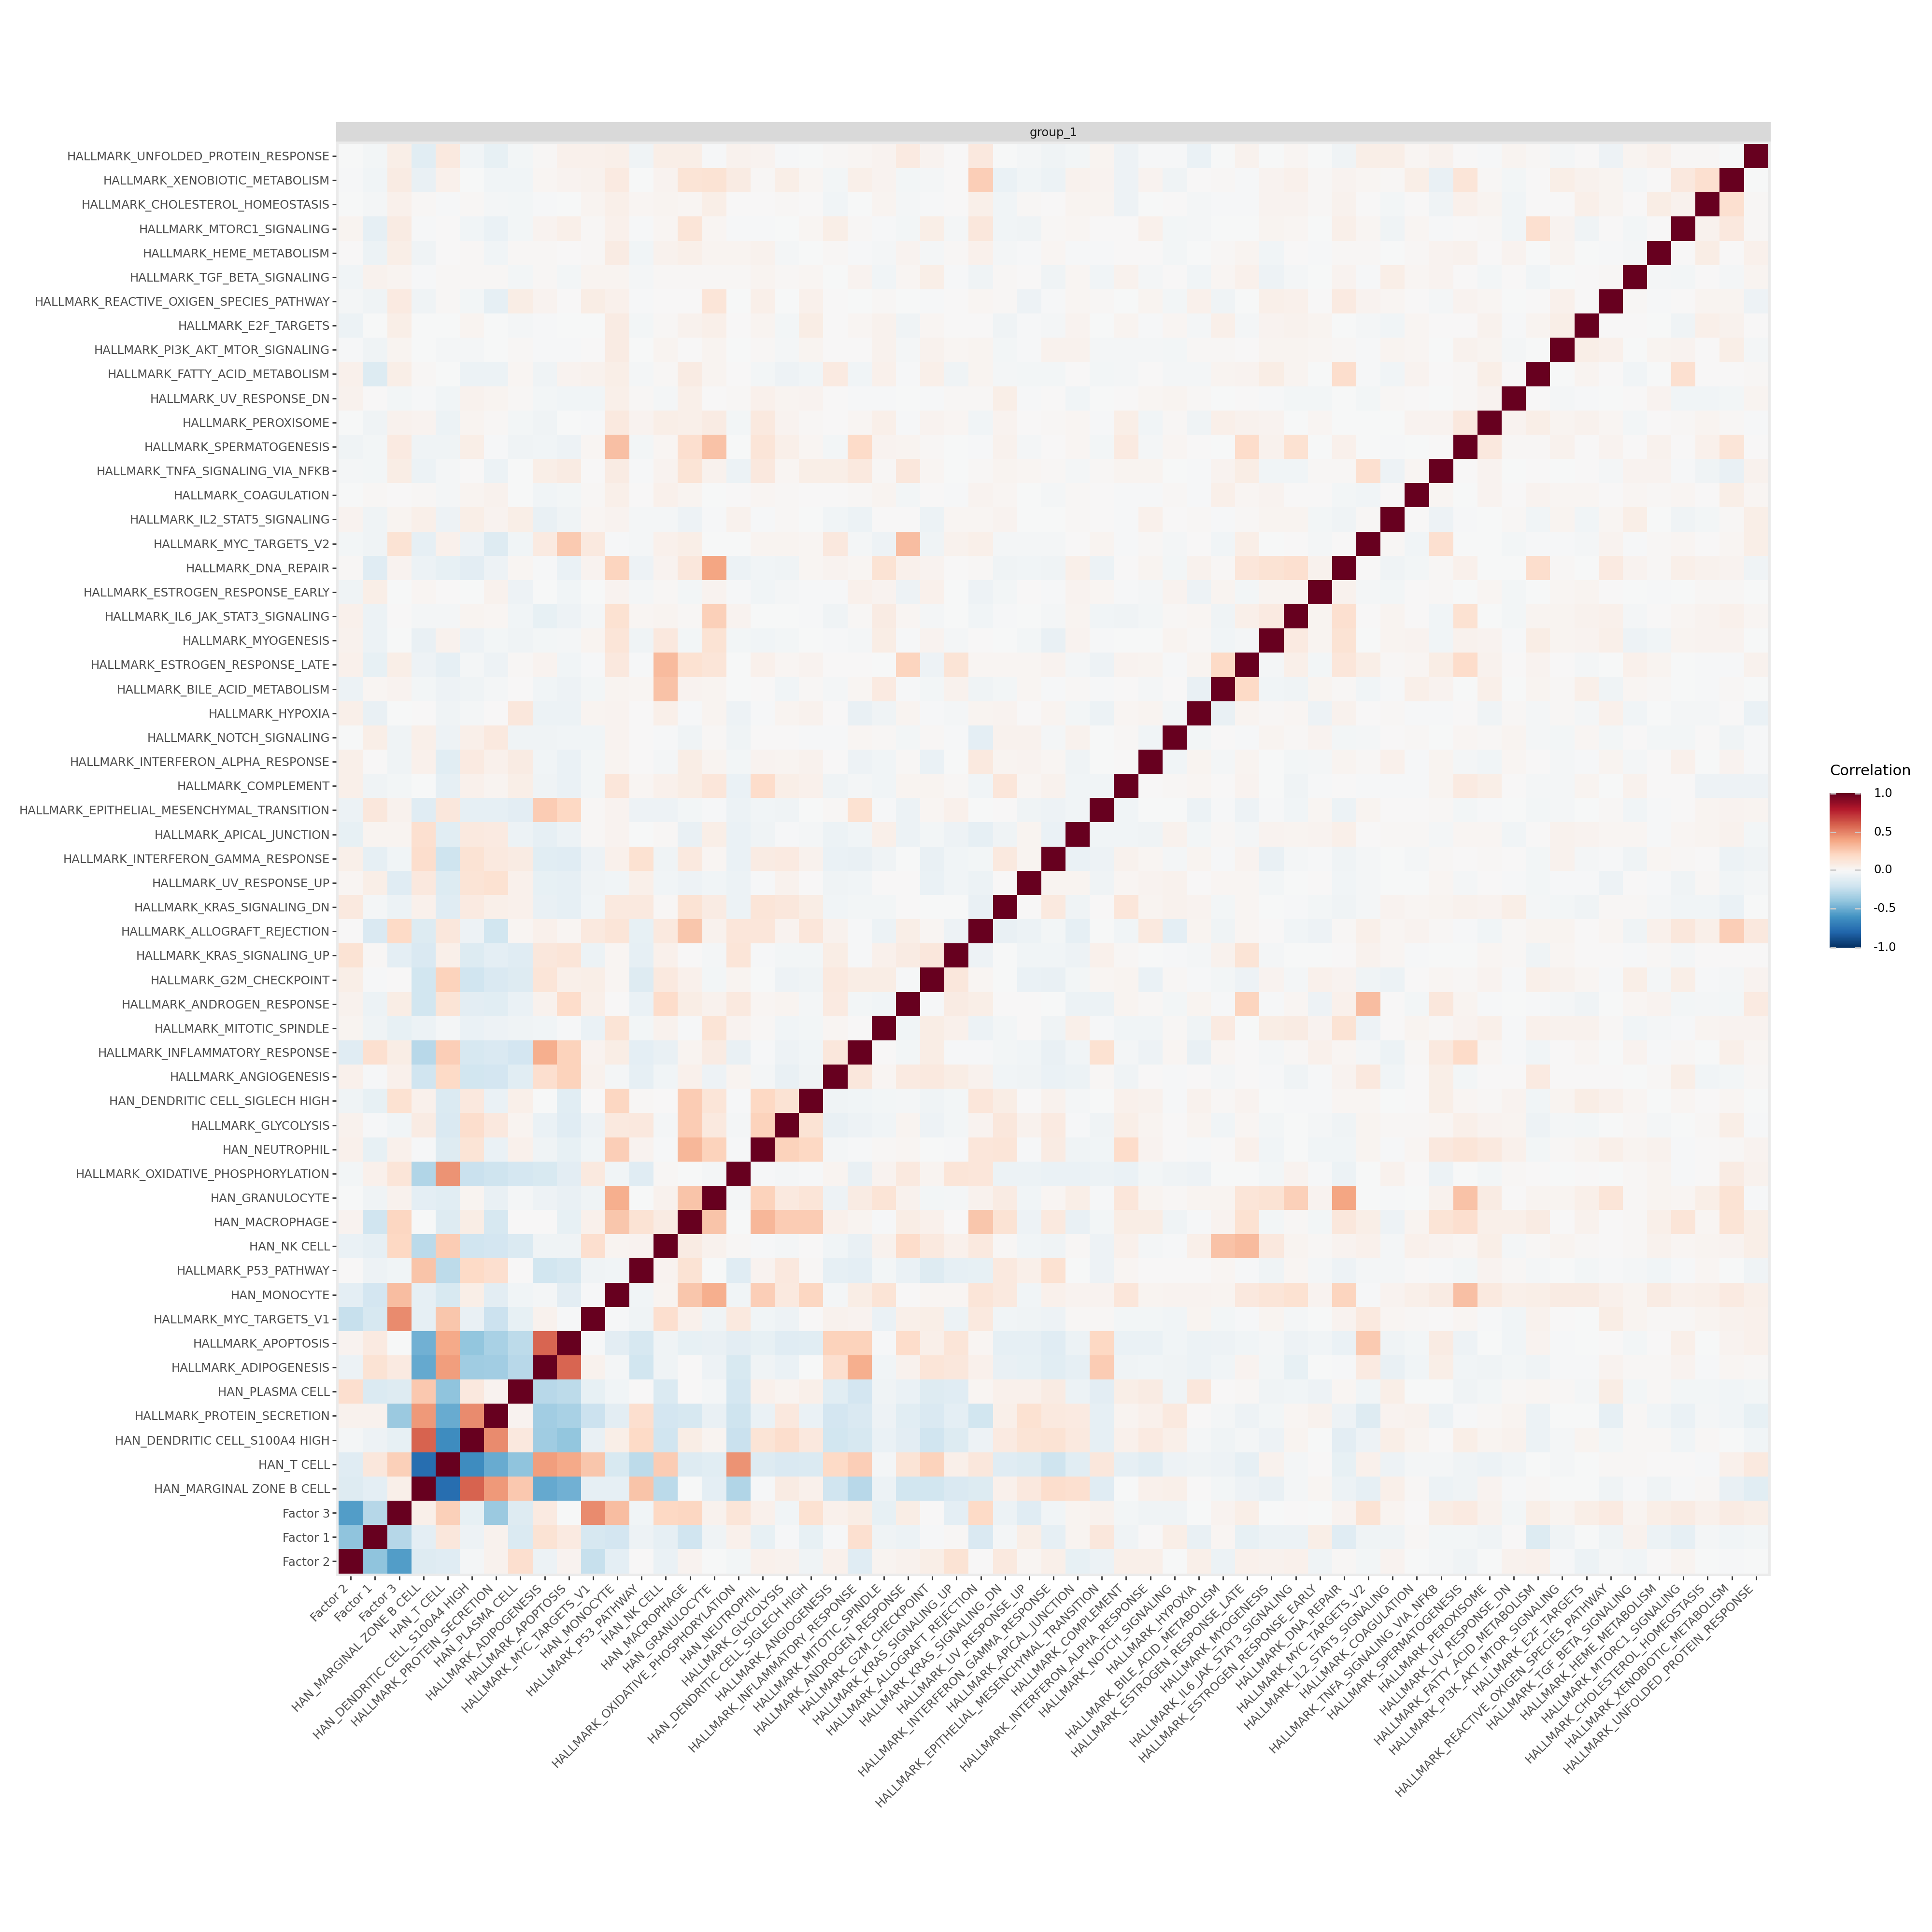

In [38]:
plotting.plot_factor_correlation(model, figsize=(20, 20))

In [39]:
factor_adata = model.get_factors("anndata")["group_1"].copy()
factor_adata

AnnData object with n_obs × n_vars = 14870 × 59
    obs: 'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source', 'cell types (high)'

In [40]:
sc.pp.neighbors(factor_adata, use_rep="X")
sc.tl.umap(factor_adata)

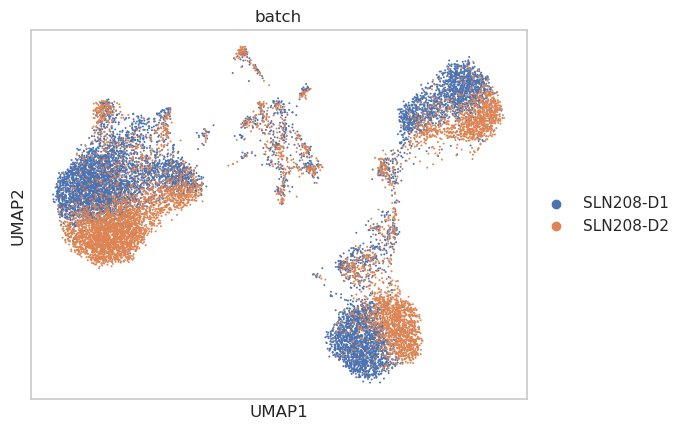

In [41]:
sc.pl.umap(factor_adata, color="batch", size=8)

In [42]:
from plotting import plot_top_weights, rank, groupplot_rank, scatter

In [43]:
sc.tl.rank_genes_groups(
    factor_adata, "batch", method="wilcoxon"
)

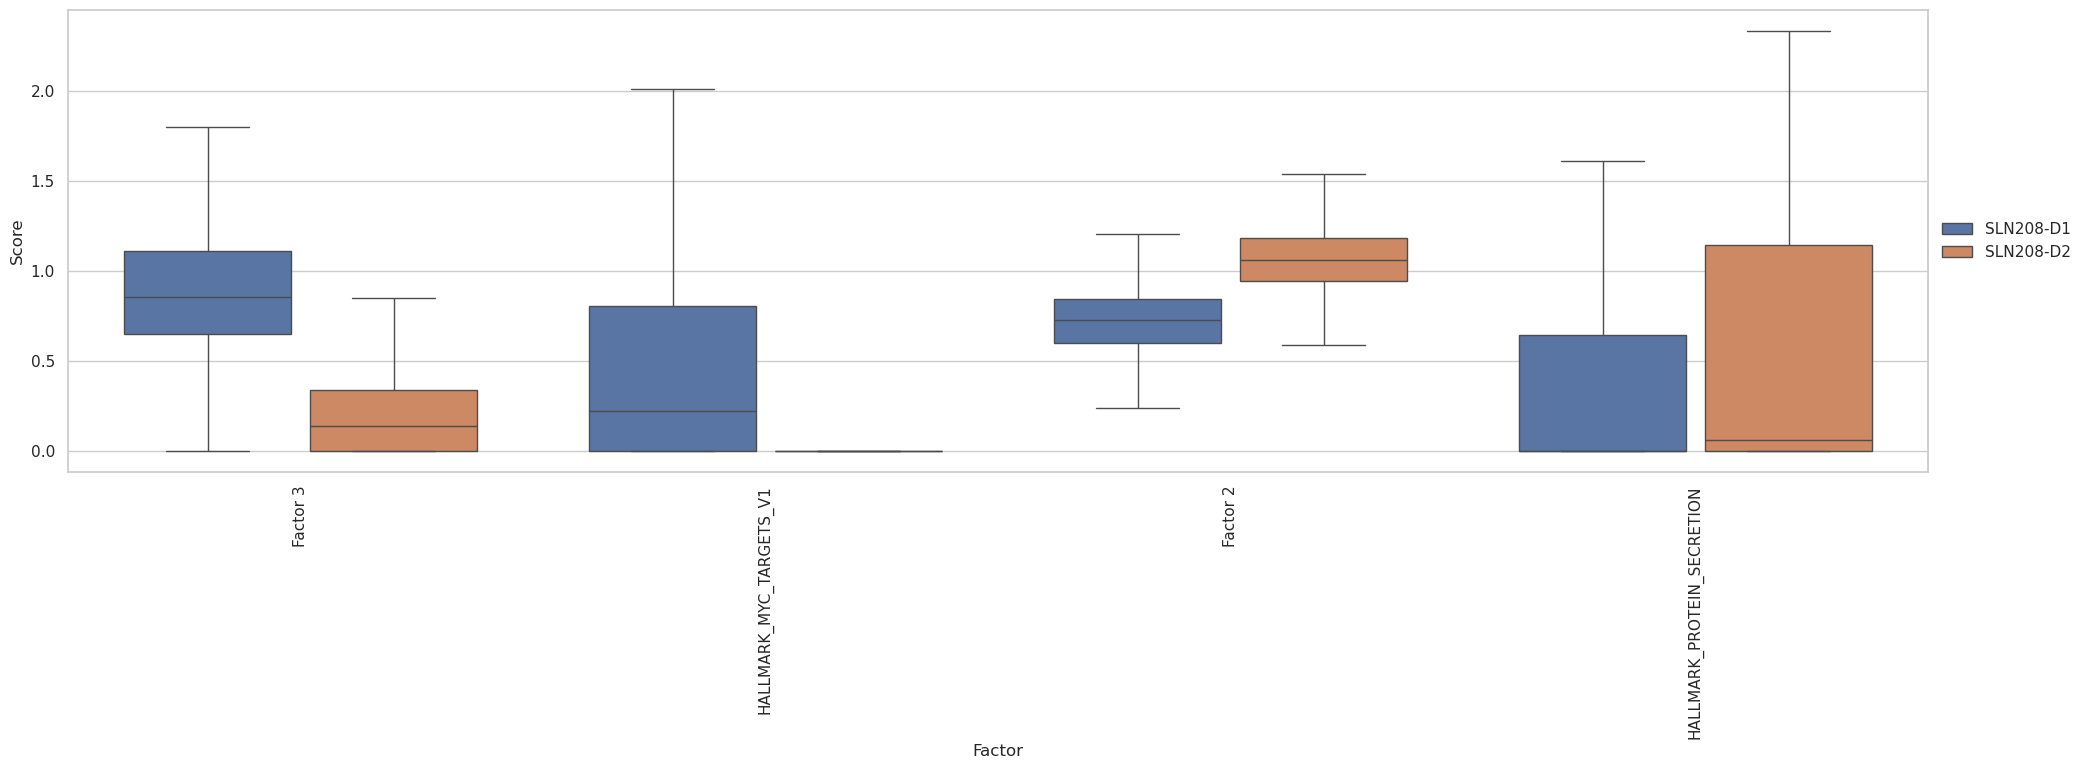

In [44]:
plt.figure(figsize=(24, 6))
batch_factors, _ = groupplot_rank(
    model, "batch", group_idx="group_1", pl_type="boxplot", top=2, gap=0.1, showfliers=False, rot=90
)

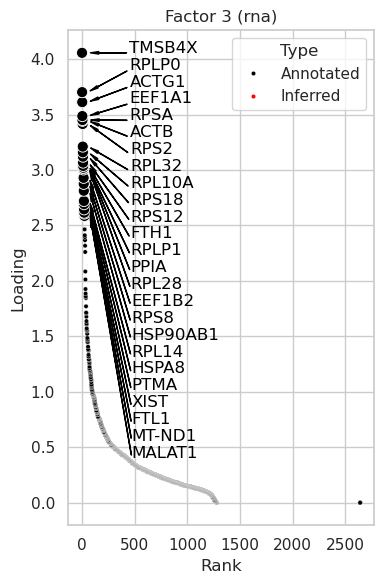

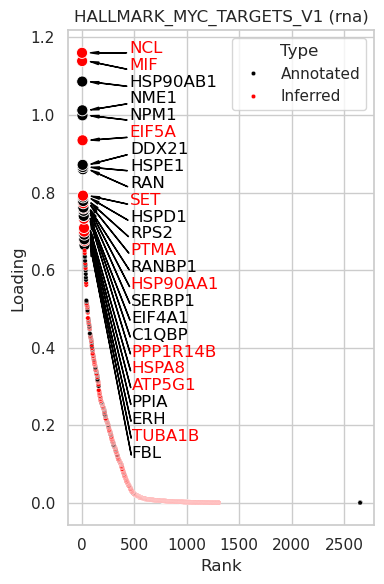

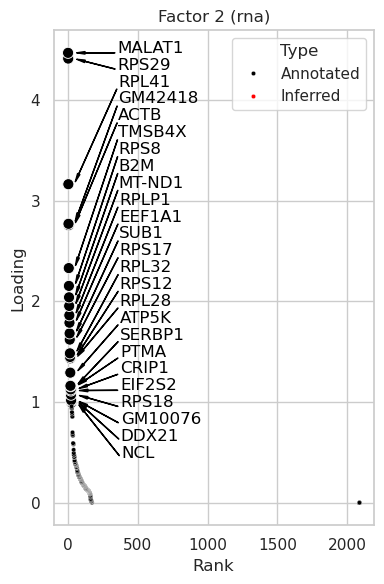

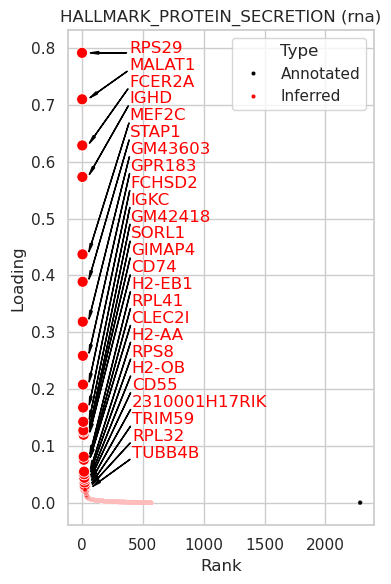

In [45]:
for rf in batch_factors:
    plot_top_weights(model, rf, view_idx="rna", top=25, ranked=True, figsize=(4,6))
    plt.show()

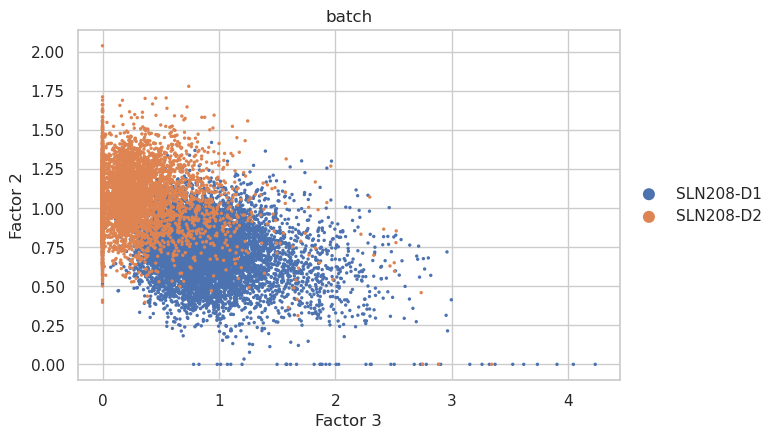

In [46]:
scatter(model, batch_factors[0], batch_factors[2], "group_1", groupby="batch", size=24)

In [47]:
factor_adata = factor_adata[:, [fn for fn in model.factor_names if fn not in batch_factors]].copy()
# factor_adata = factor_adata[:, [fn for fn in model.factor_names if "Factor" not in fn]].copy()
factor_adata

AnnData object with n_obs × n_vars = 14870 × 55
    obs: 'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source', 'cell types (high)'
    uns: 'neighbors', 'umap', 'batch_colors', 'rank_genes_groups'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [48]:
sc.pp.neighbors(factor_adata, use_rep="X")
sc.tl.umap(factor_adata)

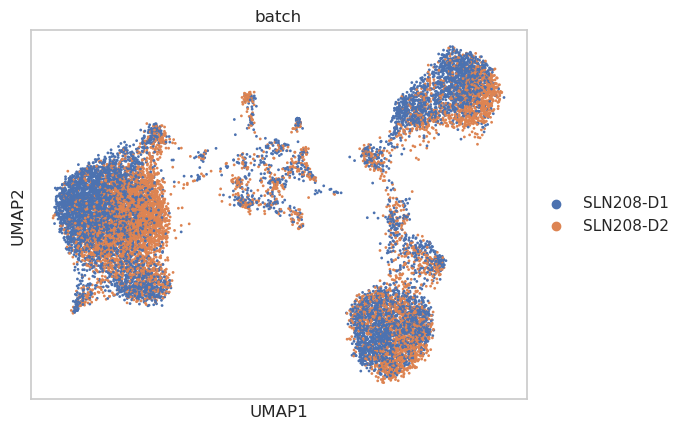

In [49]:
sc.pl.umap(factor_adata[np.random.choice(factor_adata.obs_names, size=factor_adata.n_obs, replace=False), :], color="batch", size=16)

         Falling back to preprocessing with `sc.pp.pca` and default params.


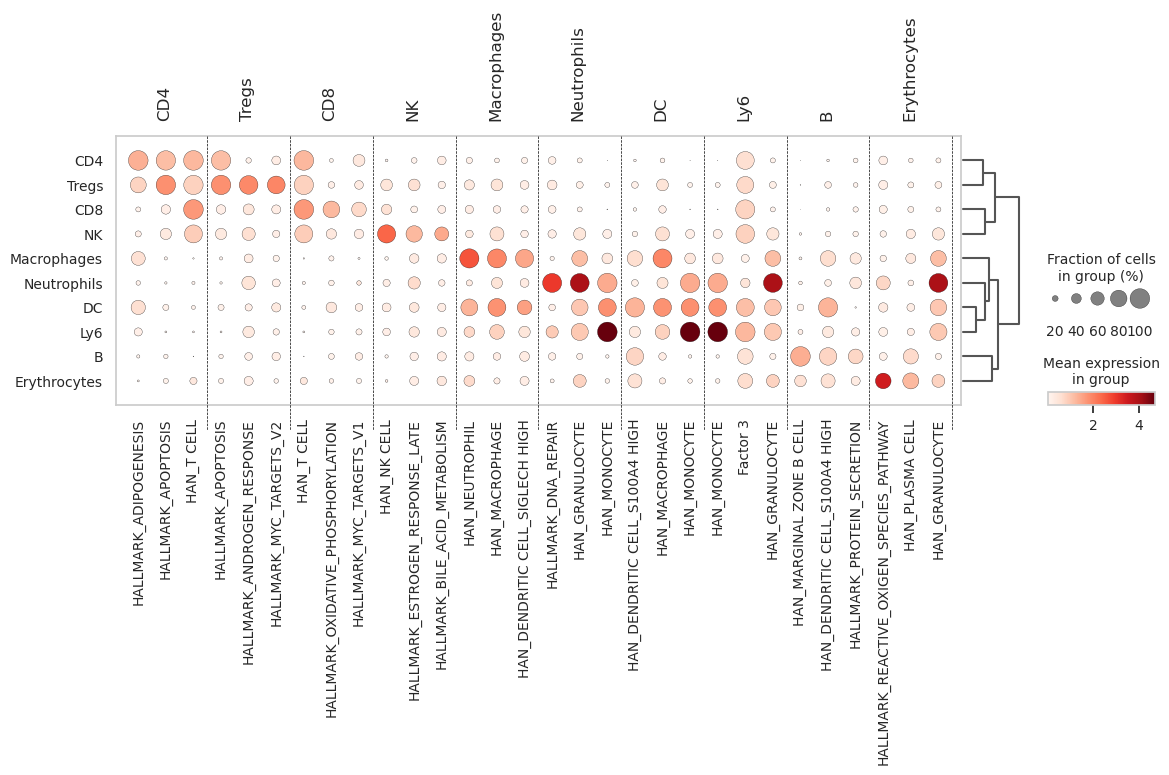

<Axes: >

In [50]:
rank(model, "cell types (high)", group_idx="group_1", n_factors=3, pl_type="dotplot", sep_groups=True)

In [51]:
from plotting import rank, groupplot_rank, scatter

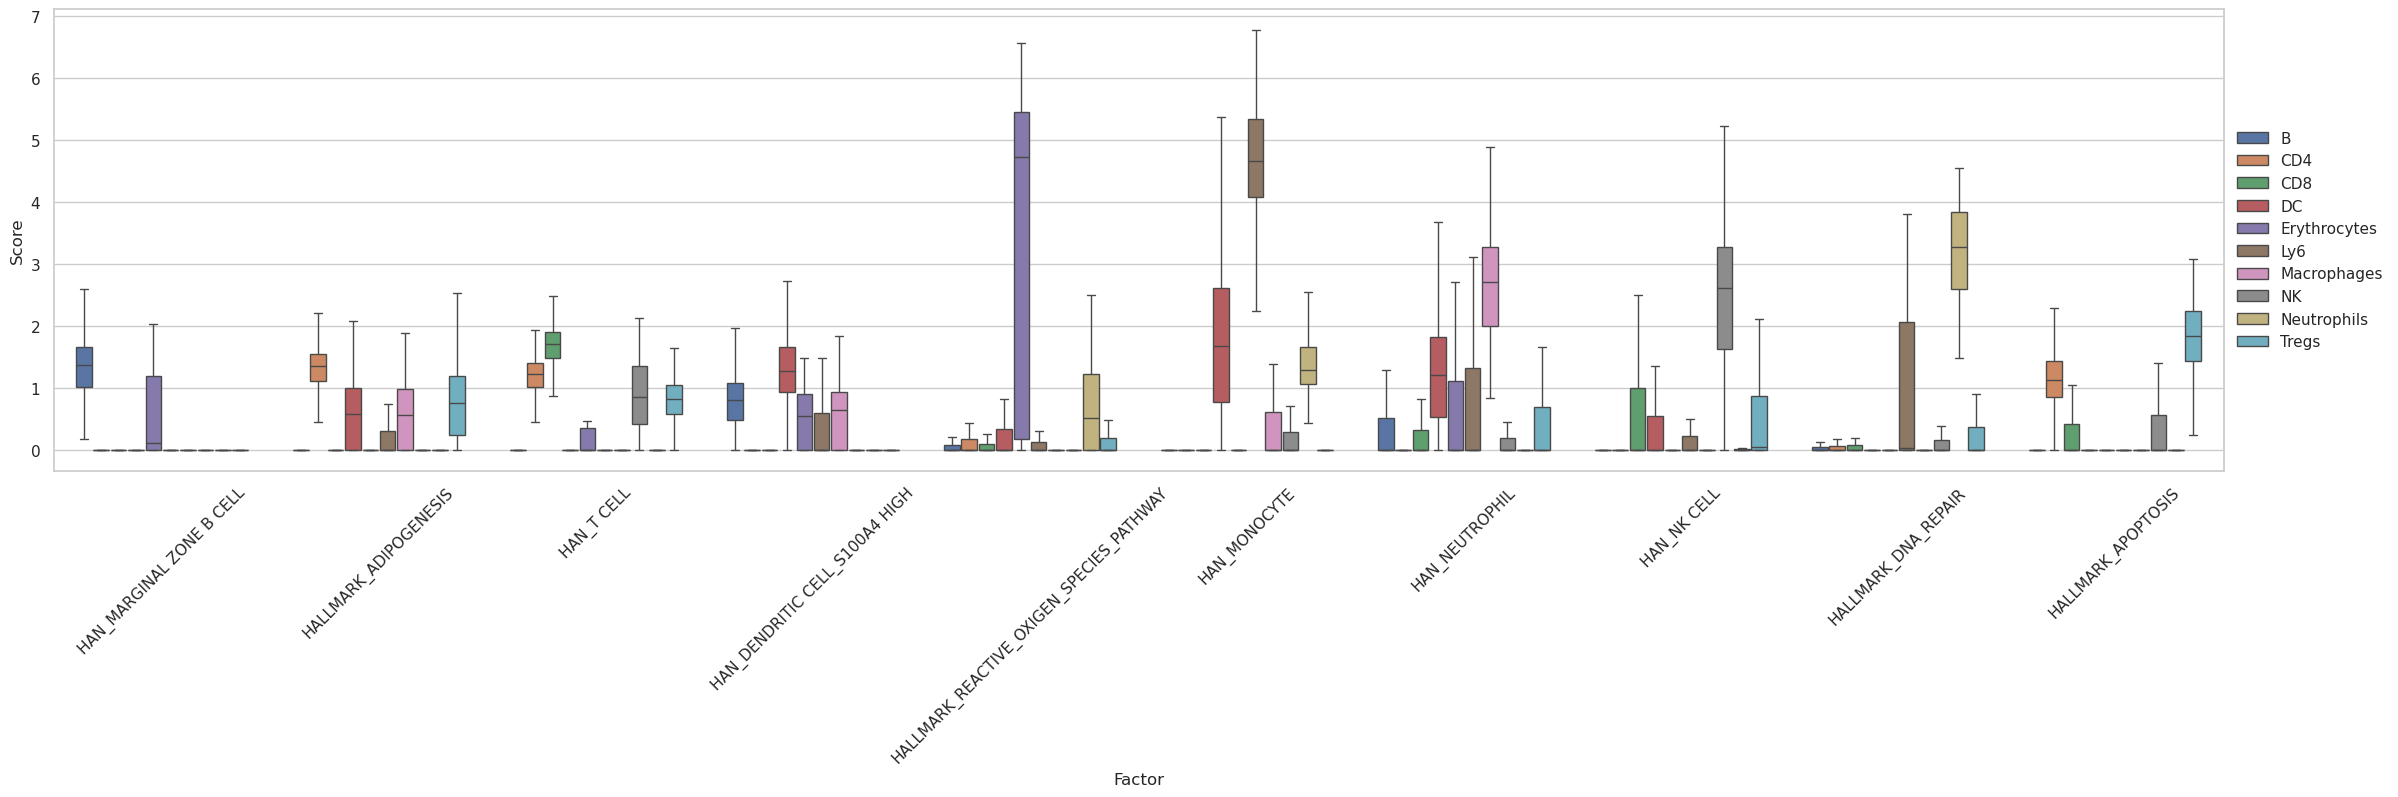

In [52]:
plt.figure(figsize=(28, 6))
celltype_factors, _ = groupplot_rank(
    model, "cell types (high)", group_idx="group_1",  pl_type="boxplot", top=1, gap=0.1, showfliers=False, rot=45
)

In [53]:
from sklearn.metrics import roc_auc_score

In [54]:
celltype_factors

['HAN_MARGINAL ZONE B CELL',
 'HALLMARK_ADIPOGENESIS',
 'HAN_T CELL',
 'HAN_DENDRITIC CELL_S100A4 HIGH',
 'HALLMARK_REACTIVE_OXIGEN_SPECIES_PATHWAY',
 'HAN_MONOCYTE',
 'HAN_NEUTROPHIL',
 'HAN_NK CELL',
 'HALLMARK_DNA_REPAIR',
 'HALLMARK_APOPTOSIS']

In [55]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "B", factor_adata.to_df().loc[:, "HAN_MARGINAL ZONE B CELL"])

0.9927170322859094

In [56]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "CD4", factor_adata.to_df().loc[:, "HALLMARK_ADIPOGENESIS"])

0.9736484127788475

In [57]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "CD8", factor_adata.to_df().loc[:, "HAN_T CELL"])

0.9684784357109119

In [58]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "DC", factor_adata.to_df().loc[:, "HAN_DENDRITIC CELL_S100A4 HIGH"])

0.863161449131651

In [59]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "NK", factor_adata.to_df().loc[:, "HAN_NK CELL"])

0.930335601243645

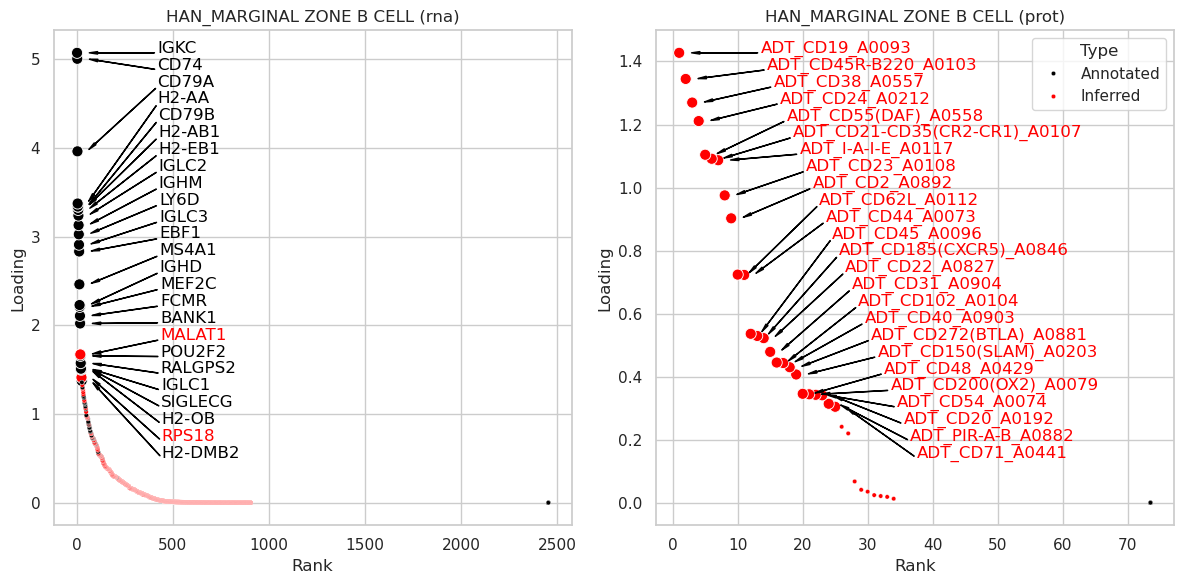

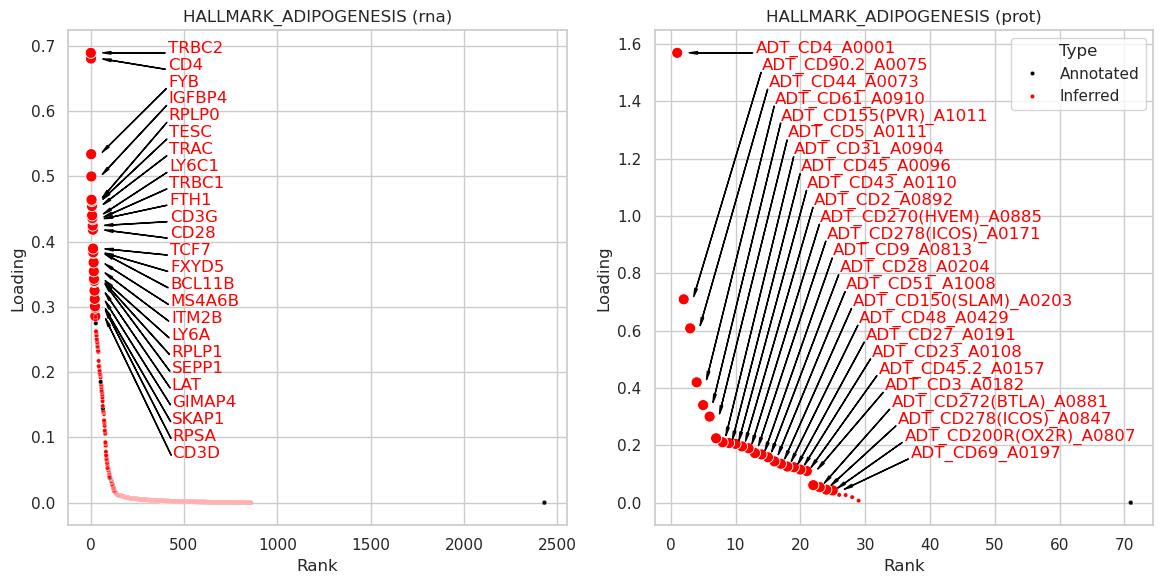

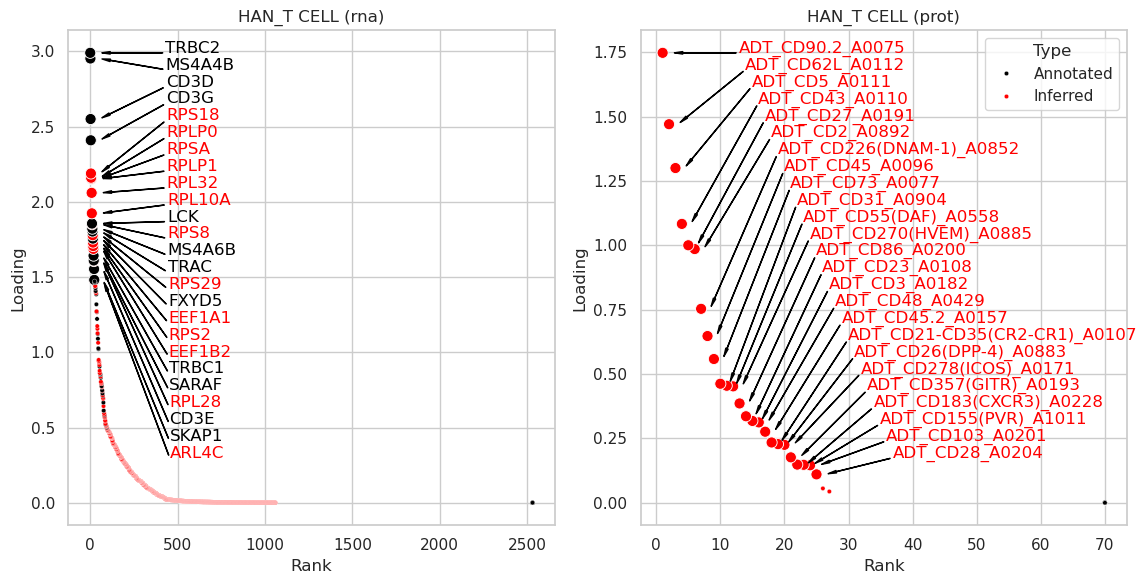

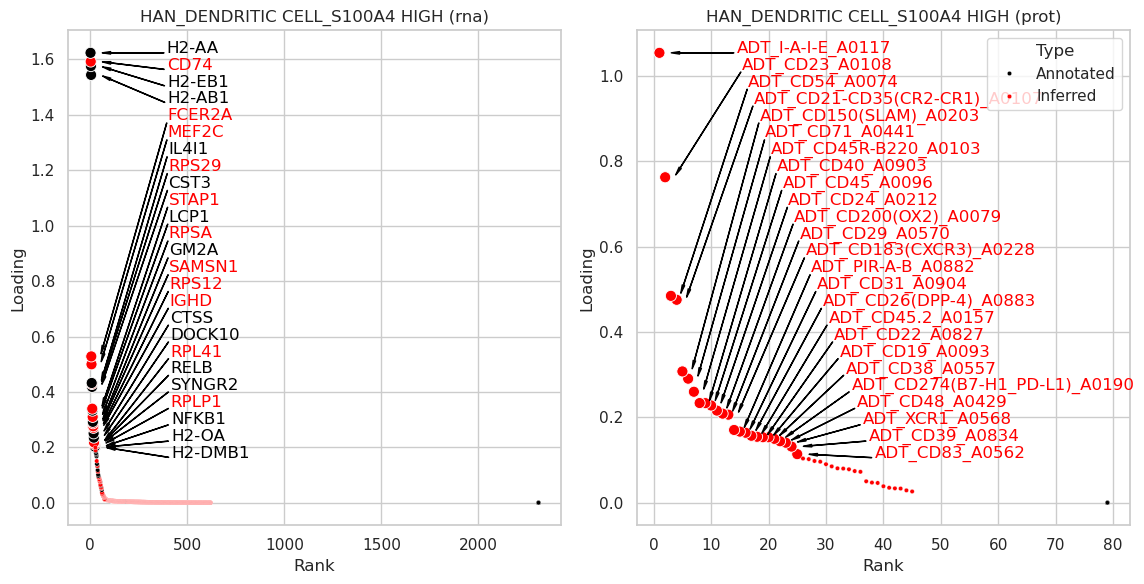

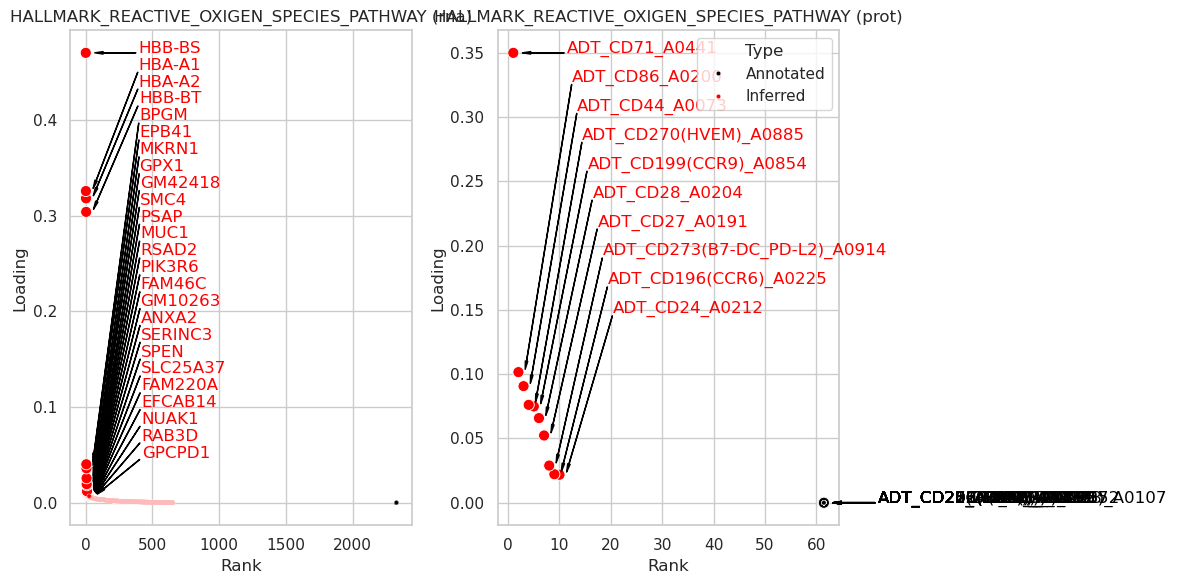

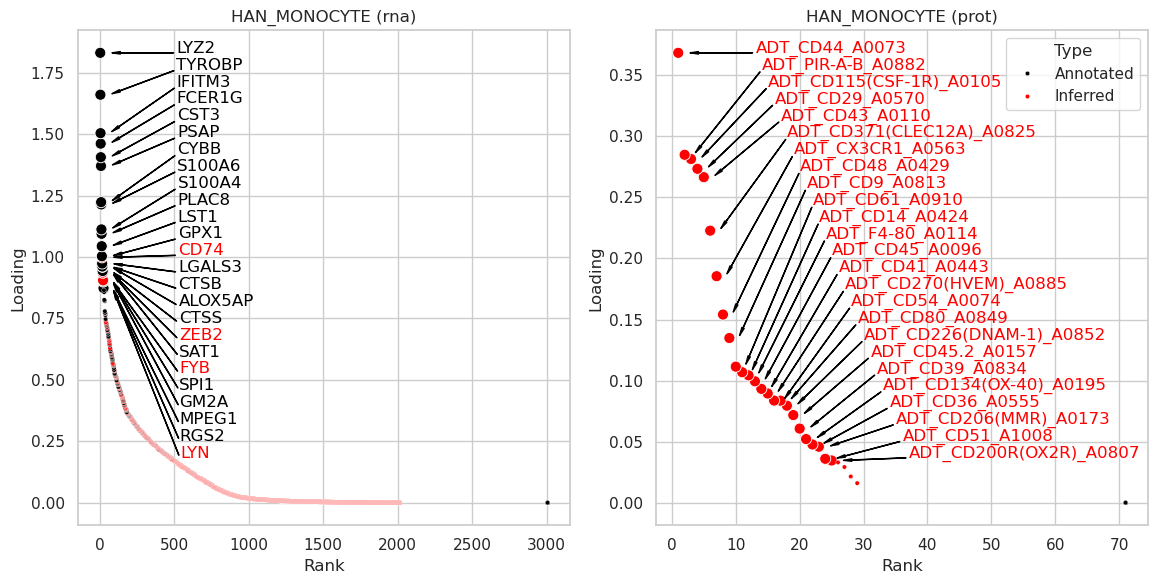

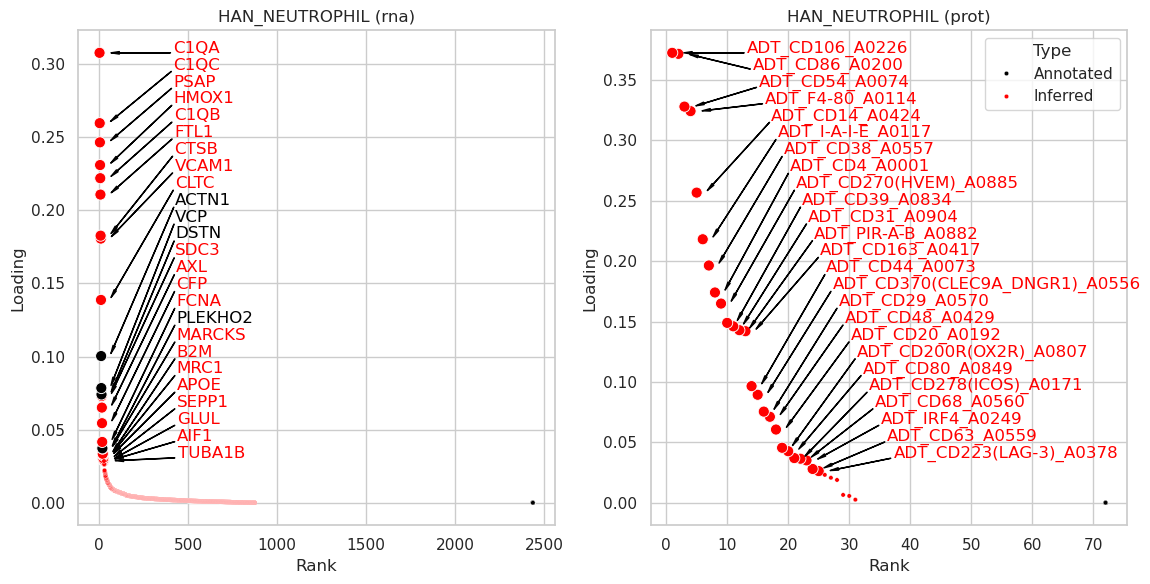

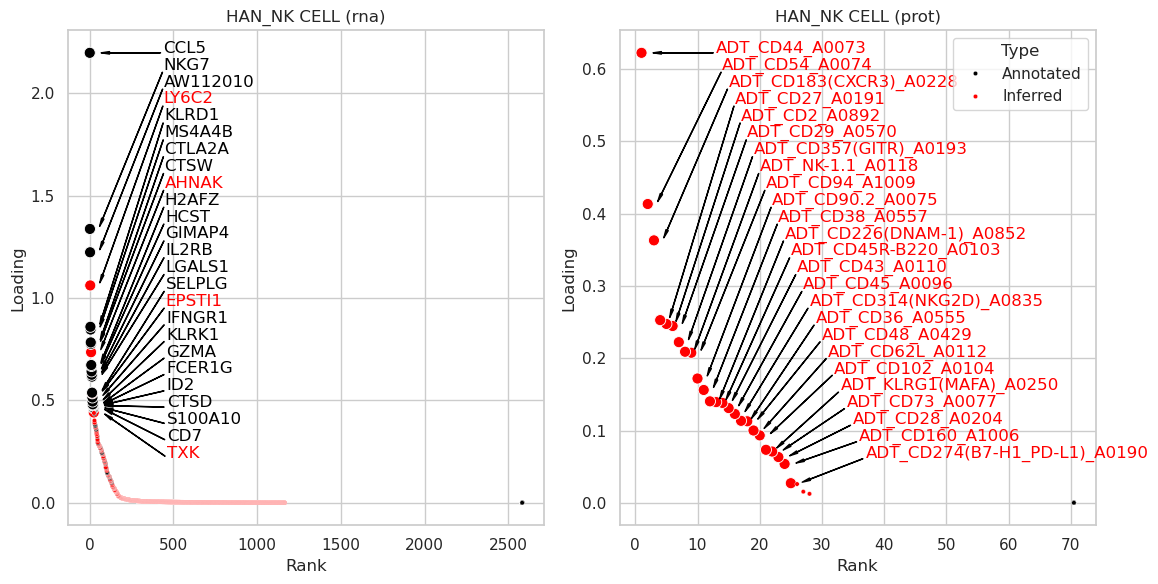

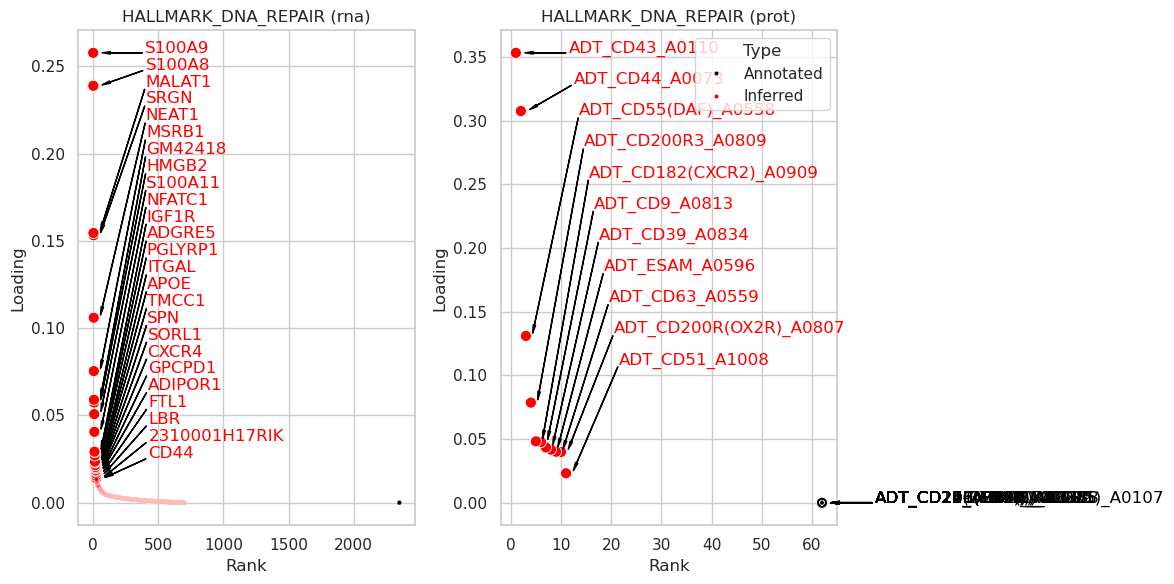

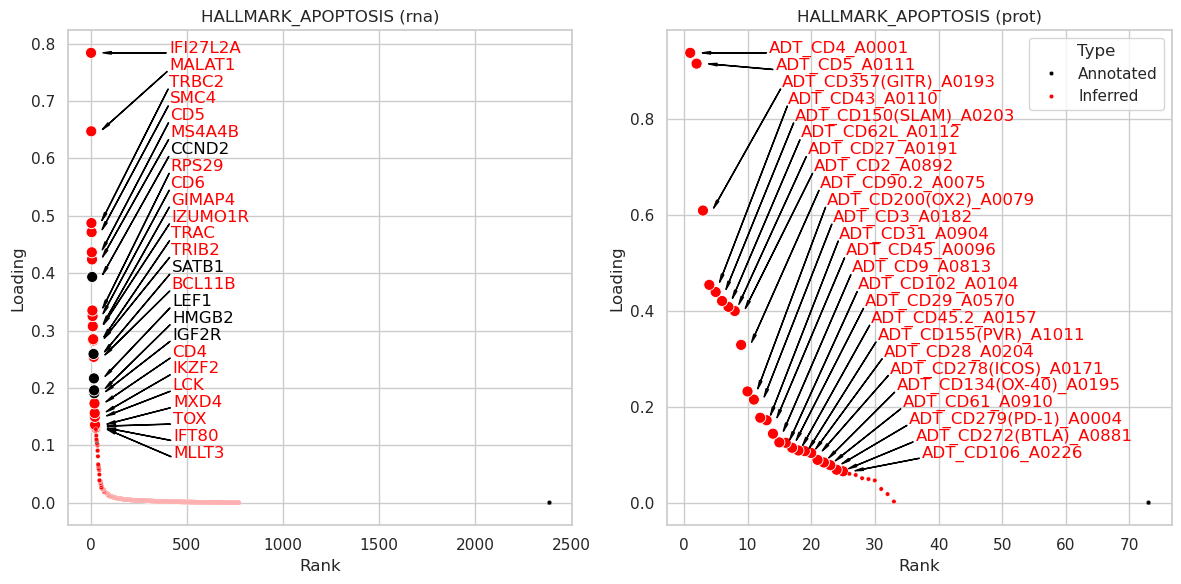

In [60]:
for rf in celltype_factors:
    plot_top_weights(model, rf, top=25, ranked=True, figsize=(12,6))
    plt.show()

In [61]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "B", factor_adata.to_df().loc[:, "Marginal Zone B Cell (Han)"])

KeyError: 'Marginal Zone B Cell (Han)'

In [ ]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "CD4", factor_adata.to_df().loc[:, "Factor 5"])

In [ ]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "CD8", factor_adata.to_df().loc[:, "T Cell (Han)"])

In [ ]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "DC", factor_adata.to_df().loc[:, "Dendritic Cell S100A4 High (Han)"])

In [ ]:
roc_auc_score(factor_adata.obs["cell types (high)"] == "NK", factor_adata.to_df().loc[:, "Nk Cell (Han)"])

In [ ]:
celltype_factors